In [ ]:
import torch.nn as nn
import torch 
import numpy as np
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np


## Dataset 

In [ ]:
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

In [ ]:
image, label = train_data[0]
image, label

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

In [ ]:
train_data.targets


In [ ]:
image.shape, label
print(f"{image.shape}: c,h,w"), label

In [ ]:
image, label = train_data[0]
print(f"Shape: {image.shape}")
image

In [ ]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

In [ ]:
torch.manual_seed(seed=42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])

In [ ]:
train_data, test_data

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Data sets to iterable (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader


In [ ]:
len(train_dataloader),len(test_dataloader)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
print(f"size: {img.shape}")

## BaseLine Model 

In [ ]:
img, label = train_data[0]
flatten = nn.Flatten()
output = flatten(img)
output.shape

In [ ]:
from torch import nn
class FashionMINST_ModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
device = "mps" if torch.mps.is_available() else "cpu"

In [ ]:
torch.manual_seed(42)

# Model with inputs 
model0 = FashionMINST_ModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)



In [ ]:
x = torch.rand([1,1,28,28]).to(device)
model0(x).shape


## Loss function, optimizer

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [ ]:
from timeit import default_timer as Timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} s")
    return total_time


## Training Loop:
- loop epochs
- loop batches, train, find loss per batch
- loop test batches, test, find test loss per batch
- print what happening
- time

In [ ]:
model0.to("cpu")

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

model0.to("cpu")

torch.manual_seed(42)
start_on_cpu = timer()

epochs = 3

# Loop epochs
for epoch in range(epochs):
    print(f"Epoch: {epoch} \n --------")

    ### Training 
    train_loss = 0

    # Loop batches 
    for batch, (X, y) in enumerate(train_dataloader):
        model0.train()

        # 1. Forward pass
        y_pred = model0(X)

        # 2. Loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss 

        # 3. Zero optimizer
        optimizer.zero_grad()

        # 4. Backprop
        loss.backward()

        # 5. Step 
        optimizer.step()

        if (batch % 400 == 0):
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader) # average loss per batch

    ### Testing
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass 
            test_pred = model0(X_test)

            # 2. Loss, acc (accumulate)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test,
                                    y_pred=test_pred.argmax(dim=1))
        
        # Average loss, acc per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Train time 
end_on_cpu = timer()
dev = next(model0.parameters()).device
total_time = print_train_time(start=start_on_cpu,
                              end=end_on_cpu,
                              device=str(dev))

## Make predictions

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=device):
    """
    Return dictionary of results of model predicting on data_loader
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Accumulate loss, acc 
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        # Average loss per batch 
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
model0_results = eval_model(model=model0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model0_results

## Model with Nonlinearity 

In [ ]:
torch.mps.is_available()
device

In [ ]:
class FashionMINST_ModelV1(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # image to single vector
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model1 = FashionMINST_ModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)


In [ ]:
next(model1.parameters()).device

### Loss, optimizer, eval metrics

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=.01)

### Function for training and testing loops

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """
    Training step with model learning on data loader
    """

    train_loss, train_acc = 0, 0

    model.train()
    # Loop batches 
    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Loss, acc
        loss = loss_fn(y_pred, y)
        train_loss += loss # acumulate loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # class go across columns

        # 3. Zero grad 
        optimizer.zero_grad()

        # 4. Backprop
        loss.backward()

        # 5. Optimizer step 
        optimizer.step()

    # Average loss, acc per batch
    train_loss /= len(train_dataloader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f} %")





In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """
    Testing loop over data loader
    """

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # Send to device 
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # Loss, acc acummulaute
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred = test_pred.argmax(dim=1))
            
        # Average per batch 
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [ ]:
torch.manual_seed(42)

# Measure time 
from timeit import default_timer as Timer
train_time_start_mps = timer()

epochs = 3

# Create optimization and eval loop with functions 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------------")

    # Training
    train_step(model=model1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    # Testing
    test_step(model=model1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_mps = timer()
train_time_model1 = print_train_time(start=train_time_start_mps,
                                     end=train_time_end_mps,
                                     device=device)

In [ ]:
model0_results

In [ ]:
model1_results = eval_model(model=model1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

In [ ]:
model1_results

In [ ]:
model0_results

## Model 2: Building CNN

In [ ]:
class FashionMINST_ModelV2(nn.Module):
    """
    Replicates TinyVGG model
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # 3x3
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Conv1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Conv2: {x.shape}")
        x = self.classifier(x)
        # print(f"Classifier: {x.shape}")
        return x
        

In [ ]:
torch.manual_seed(42)

model2 = FashionMINST_ModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

### Step through nn.Conv2d()

In [ ]:
torch.manual_seed(42)

# Batch of images 
images = torch.randn(size=(32,3,64,64))

test_image = images[0]

test_image.shape, images.shape, test_image

In [ ]:
# Single conv2d layer 
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1)

In [ ]:
tensor = torch.randn(size=(1,1,28,28))
model2(tensor.to(device))

## Loss function and optimizer 

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(),
                            lr=.01)

In [191]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

from timeit import default_timer as timer 
start = timer()

# Train and test 
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n----------")

    # Training 
    train_step(model=model2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    # Testing 
    test_step(model=model2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

end = timer()
time = print_train_time(start=start,
                        end=end,
                        device=device)

Epoch: 0
----------
Train loss: 0.91078 | Train acc: 67.65 %
Test loss: 0.63064 | Test acc: 76.38%
Epoch: 1
----------
Train loss: 0.51928 | Train acc: 81.45 %
Test loss: 0.53716 | Test acc: 80.40%
Epoch: 2
----------
Train loss: 0.44858 | Train acc: 84.18 %
Test loss: 0.48859 | Test acc: 82.53%
Train time on mps: 22.808 s


In [192]:
model2_results = eval_model(model=model2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)

In [193]:
model2_results

{'model_name': 'FashionMINST_ModelV2',
 'model_loss': 0.48859134316444397,
 'model_acc': 82.52795527156549}

In [194]:
model1_results

{'model_name': 'FashionMINST_ModelV1',
 'model_loss': 0.9579175114631653,
 'model_acc': 65.68490415335464}

In [197]:
import pandas as pd 
results = pd.DataFrame([model0_results,
                       model1_results,
                       model2_results])

In [198]:
results

,model_name,model_loss,model_acc
0,FashionMINST_ModelV0,0.503165,82.478035
1,FashionMINST_ModelV1,0.957918,65.684904
2,FashionMINST_ModelV2,0.488591,82.527955


<Axes: ylabel='model_name'>

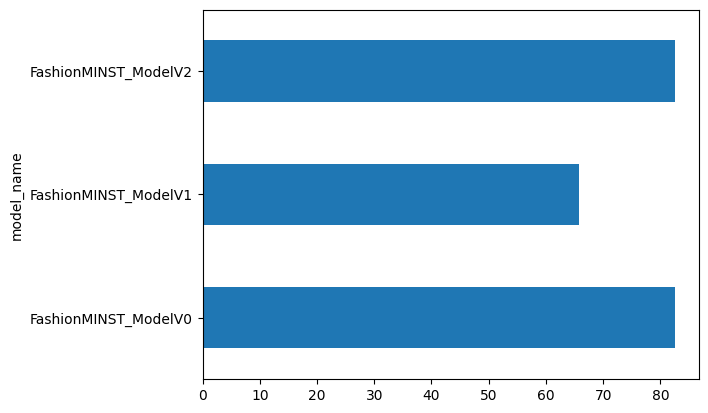

In [199]:
results.set_index("model_name")["model_acc"].plot(kind='barh')

# Make predictions 

In [202]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
    pred_probs = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Prepare sample: add batch dimensions, pass to device 
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forwad pass: raw logits
            pred_logit = model(sample)

            # Prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Append, move off mps
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [208]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [211]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

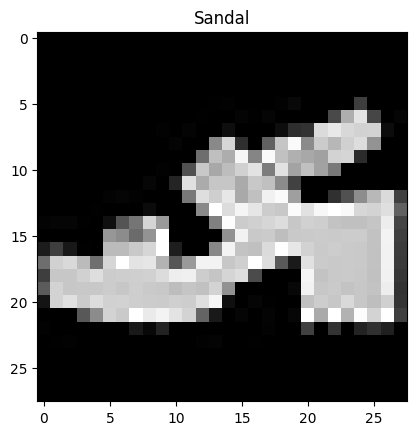

In [217]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [220]:
# make predictions 
pred_probs = make_predictions(model=model2,
                              data=test_samples)

pred_probs

tensor([[9.4965e-08, 2.3947e-08, 1.9874e-07, 4.7551e-07, 1.1811e-07, 9.0758e-01,
         3.3958e-07, 8.8882e-04, 2.9671e-04, 9.1235e-02],
        [1.5318e-02, 4.1995e-01, 3.8545e-04, 4.6654e-01, 6.6837e-02, 8.2429e-06,
         2.8087e-02, 3.3898e-05, 2.8440e-03, 5.2233e-06],
        [1.7882e-07, 4.1528e-08, 3.6812e-07, 9.7053e-07, 3.4663e-07, 1.8581e-03,
         4.1012e-07, 7.6048e-01, 8.7696e-04, 2.3679e-01],
        [7.5778e-04, 1.6166e-04, 1.5605e-01, 1.5323e-03, 8.3142e-01, 3.6050e-09,
         9.7406e-03, 5.6022e-09, 3.3695e-04, 3.5829e-09],
        [1.8070e-02, 3.1613e-04, 2.7827e-05, 9.7694e-01, 3.7077e-05, 1.3188e-08,
         4.5869e-03, 1.0746e-06, 2.0476e-05, 4.9874e-06],
        [6.6365e-01, 2.6324e-04, 2.6912e-04, 3.4802e-03, 2.1779e-03, 1.3933e-08,
         3.3010e-01, 4.8627e-08, 5.9340e-05, 9.7733e-08],
        [5.1156e-06, 1.8378e-05, 2.6460e-03, 3.4014e-07, 9.8913e-01, 2.7971e-08,
         8.1581e-03, 1.3548e-10, 4.5516e-05, 5.4403e-09],
        [3.3401e-04, 4.8496

In [221]:
# Convert prediction probs to labels 
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 3, 7, 4, 3, 0, 4, 7, 1])

In [222]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]